In [1]:
import pandas as pd
import nltk
import re
import json
from nltk.corpus import stopwords 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import spacy
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.cluster import DBSCAN, AgglomerativeClustering, KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, mean_squared_error
import torch
from transformers import AutoTokenizer, AutoModel

# Проблематика

В Росатоме разработан и применяется на рынке сервис для проведения интерактивных онлайн-опросов «Мой голос». Одним из способов получения данных является возможность ввода произвольных ответов на открытые вопросы. Для более качественной обработки и наглядной визуализации ответов сервис объединяет в группы пользовательские ответы, семантически близкие друг к другу. От качества такой группировки зависит корректность представления итоговых результатов, правильность их интерпретации и, как следствие, общая удовлетворенность сервисом со стороны пользователей. Команда разработчиков ищет способы постоянного повышения качества группировки ответов. Объединение ответов должно проводиться с учётом возможных ошибок, опечаток, применяемых пользователями сокращений.
Семантическая близость определяется схожестью между собой ответов по смыслу и тональности (положительная, нейтральная, негативная).<br>
С целью улучшения пользовательского опыта процесс обработки должен осуществляться как в онлайн - режиме (на лету, еще до завершения опроса), так и в финальной редакции (после завершения опроса).
При этом важно обеспечить минимальную задержку по времени до получения конечного результата.<br>
Перед нами стоит задача первичной обработки и кластеризации текстовых ответов пользователей для дальнейшей визуализации на сайте с онлайн-опросами.

# Первичный выбор модели

Загрузим самый большой датасет и подготовим его к обучению модели, тут нам нужен только текст, сам вопрос можно опустить

In [2]:
# Загрузка данных из JSON файла
with open("D:\datasets/all/19747.json", 'r') as f:
    data = json.load(f)

# Создаем список, в котором каждый элемент повторяется соответствующее количество раз
text_list = [item['answer'] for item in data['answers']]
text_series = pd.Series(text_list, name='text')
text_series.head()

0              нарушение  тб
1         безответственность
2           невнимательность
3        недостаток обучения
4    непонимание техпроцесса
Name: text, dtype: object

In [3]:
text_series.count()

452

Очистим тексты с помощью регулярных выражений:

1. Приведем все к нижнему регистру
2. Удалим спец символы 
3. Выберем только слова

In [4]:
def clean(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Zа-яА-Я ]+", "", text).strip()
    return text

Лемматизация

In [5]:
nlp = spacy.load("ru_core_news_sm")
def lemmatize_spacy(text):
    return " ".join([token.lemma_ for token in nlp(text)])

In [6]:
%%time
# очищаем и лемматизируем текст
corpus = text_series.apply(clean).apply(lemmatize_spacy)

Wall time: 3.01 s


In [7]:
corpus.head(10)

0                    нарушение   тб
1                безответственность
2                  невнимательность
3               недостаток обучение
4           непонимание техпроцесса
5                        отвлечение
6    формальный отношение к безопас
7                        халатность
8                        халатность
9            низкий ответственность
Name: text, dtype: object

Подготовим текст, попробуем векторизовать TfIdf для первичного отбора модели

In [8]:
stopwords_russian = stopwords.words('russian')
stopwords_english = stopwords.words('english')
all_stopwords = set(stopwords_russian + stopwords_english)
tf_idf = TfidfVectorizer(stop_words=all_stopwords)
corpus_vec = tf_idf.fit_transform(corpus)

Подберем оптимальное кол-во кластеров методом локтя

In [9]:
def determine_k(embeddings):
    k_min = 10
    clusters = [x for x in range(2, k_min * 11)]
    metrics = []
    for i in clusters:
        metrics.append((KMeans(n_clusters=i).fit(embeddings)).inertia_)
    k = elbow(k_min, clusters, metrics)
    return k

def elbow(k_min, clusters, metrics):
    score = []

    for i in range(k_min, clusters[-3]):
        y1 = np.array(metrics)[:i + 1]
        y2 = np.array(metrics)[i:]
    
        df1 = pd.DataFrame({'x': clusters[:i + 1], 'y': y1})
        df2 = pd.DataFrame({'x': clusters[i:], 'y': y2})
    
        reg1 = LinearRegression().fit(np.asarray(df1.x).reshape(-1, 1), df1.y)
        reg2 = LinearRegression().fit(np.asarray(df2.x).reshape(-1, 1), df2.y)

        y1_pred = reg1.predict(np.asarray(df1.x).reshape(-1, 1))
        y2_pred = reg2.predict(np.asarray(df2.x).reshape(-1, 1))    
        
        score.append(mean_squared_error(y1, y1_pred) + mean_squared_error(y2, y2_pred))

    return np.argmin(score) + k_min

k = determine_k(corpus_vec)

Подбор оптимального кол-ва кластеров происходит достаточно долго в автоматическом режиме, нужно попробовать алгоритм, который сам определяет их количество

## К-Means

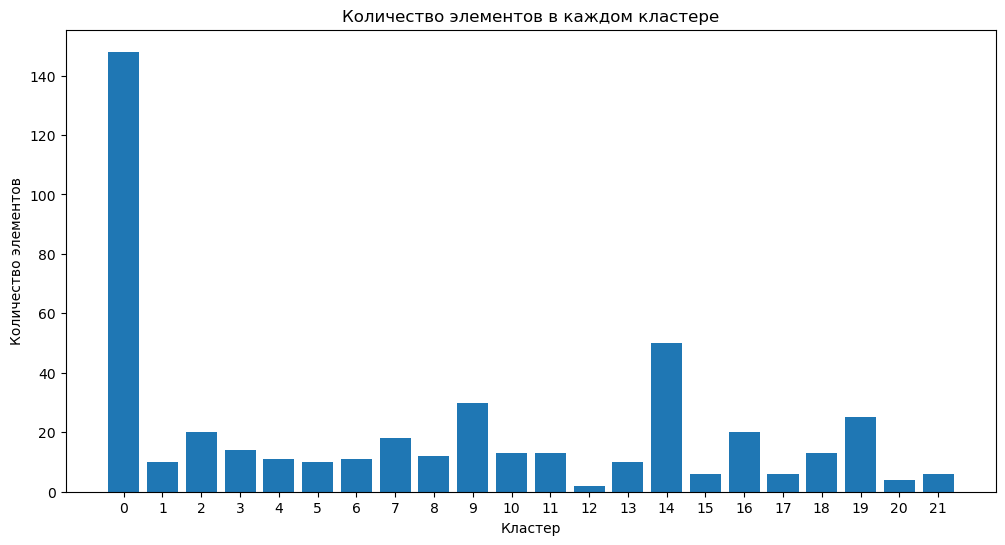

In [10]:
kmeans = KMeans(n_clusters=k, random_state=12345).fit(corpus_vec)

labels = kmeans.labels_
cluster_counts = [len(labels[labels == i]) for i in range(k)]

plt.figure(figsize=(12, 6))
plt.bar(range(k), cluster_counts, tick_label=[f'{i}' for i in range(k)])
plt.xlabel('Кластер')
plt.ylabel('Количество элементов')
plt.title('Количество элементов в каждом кластере')
plt.show()

In [11]:
# Получаем центроиды кластеров
centroids = kmeans.cluster_centers_

# Получаем индексы наиболее близких к центроиду слов
top_words_indices = centroids.argsort()[:, ::-1][:, :10]  # Здесь 10 - количество наиболее частых слов

# Получаем список всех слов
all_words = tf_idf.get_feature_names_out()

# Для каждого кластера выводим наиболее частые слова
for i, cluster_indices in enumerate(top_words_indices):
    top_words = [all_words[idx] for idx in cluster_indices]
    print(f"Кластер {i}: {', '.join(top_words)}")

Кластер 0: формализм, авось, план, отношение, обучение, нарушение, недостаток, инструкция, снижение, правило
Кластер 1: требование, несоблюдение, правило, безопасно, исполнение, соблюдение, нарушение, лна, безопа, техника
Кластер 2: халатность, работник, личный, это, отношение, информированность, линрук, культура, куча, легкомысленный
Кластер 3: формальный, подход, отношение, обучение, изменяться, инструктаж, безопас, работа, кб, мастер
Кластер 4: дисциплина, трудовой, низкий, рабочий, исполнительский, труд, произв, слабый, лень, нарушение
Кластер 5: срок, гонка, сжать, исполнение, показатель, производство, приоритет, цена, продукт, новый
Кластер 6: тб, соблюдение, правило, нарушение, несоблюдение, требов, беспечный, самонадеяннос, безопаснос, треб
Кластер 7: безответственность, руководител, лень, рабочий, личный, работник, выг, псих, это, линейно
Кластер 8: невнимательность, работник, неосведомлен, это, линрук, культура, куча, легкомысленный, лень, лидерство
Кластер 9: низкий, квалифи

Количество кластеров получилось слишком большим, их состав близок к хорошему результату, нужно попробовать другие варианты моделей.

## DBSCAN

In [12]:
hdb = DBSCAN(eps=0.8, n_jobs=-1).fit(corpus_vec)
hdb.labels_

array([-1,  0,  1, -1, -1, -1, -1,  2,  2, -1,  3, -1, -1, -1, -1, -1, -1,
        4,  0, -1,  2, -1, -1, -1, -1,  5, -1,  6, -1, -1, -1,  1,  4,  7,
       -1,  3,  7, -1,  3, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        8, -1,  5, -1,  2, -1, -1,  2,  2, -1,  7,  0, -1,  2, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  9, -1, -1, -1, -1, -1,
       -1, -1, -1, -1,  7, -1,  9, -1, -1, -1,  5, -1, -1, -1, -1, -1, -1,
        0, -1, -1, -1, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1,  3, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1,  3,  9, -1, -1, -1, -1, -1, -1,
       -1, -1, -1,  3, -1, -1, -1, -1,  6,  1, -1, -1, -1, -1,  7, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, 10, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, 11, -1,  6,  9, -1, -1,  4, -1, -1,  9, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1,  5, -1, -1, -1, -1, -1, -1, -1,  9, -1, -1,
        1, -1, -1,  2, -1

DBSCAN помечает почти все как шум, что не подходит для нашей задачи

## Agglomerative Clustering

Попробуем сделать меньшее количество кластеров, чтобы было удобнее их визуализировать

In [13]:
agg_clustering = AgglomerativeClustering(n_clusters=8)
clusters = agg_clustering.fit_predict(corpus_vec.toarray())

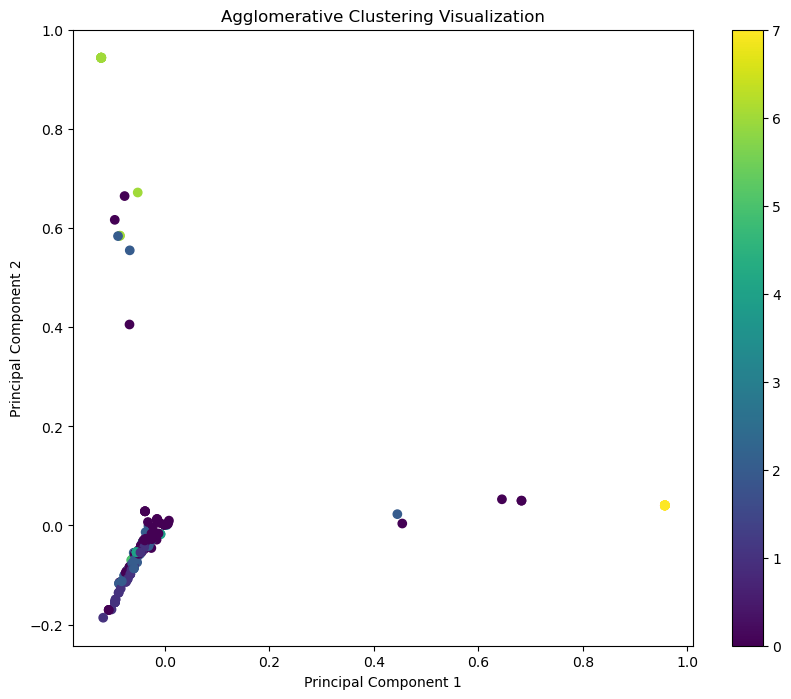

In [14]:
# Понижаем размерность до 2-х компонент с PCA
pca = PCA(n_components=2)
transformed_features = pca.fit_transform(corpus_vec.toarray())
# Визуализация
plt.figure(figsize=(10, 8))
plt.scatter(transformed_features[:, 0], transformed_features[:, 1], c=clusters, cmap='viridis')
plt.title('Agglomerative Clustering Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar()
plt.show()

In [15]:
# функция для определения топ 3 слов в кластере
def top_tfidf_words(cluster_label, tfidf_matrix, feature_names, clusters, top_n=3):
    cluster_indices = np.where(clusters == cluster_label)[0]
    cluster_tfidf_scores = tfidf_matrix[cluster_indices].sum(axis=0).A1
    top_indices = np.argsort(cluster_tfidf_scores)[::-1][:top_n]
    top_words = [feature_names[i] for i in top_indices]
    return top_words

In [16]:
feature_names = tf_idf.get_feature_names_out()
for cluster_label in np.unique(clusters):
    top_words = top_tfidf_words(cluster_label, corpus_vec, feature_names, clusters)
    print(f'Cluster {cluster_label}: {top_words}')

Cluster 0: ['отсутствие', 'личный', 'работа']
Cluster 1: ['контроль', 'недостаточный', 'руководитель']
Cluster 2: ['низкий', 'дисциплина', 'ответственность']
Cluster 3: ['самоуверенность', 'безразличие', 'деятельность']
Cluster 4: ['невнимательность', 'работник', 'неосведомлен']
Cluster 5: ['формальный', 'подход', 'обучение']
Cluster 6: ['безответственность', 'руководител', 'работник']
Cluster 7: ['халатность', 'это', 'коренной']


In [17]:
print("Качество кластеризации по метрике силуэтта %.3f" % silhouette_score(corpus_vec.toarray(), agg_clustering.labels_))
print(f'Davies Bouldin Score: {davies_bouldin_score(corpus_vec.toarray(), agg_clustering.labels_)}')

Качество кластеризации по метрике силуэтта 0.109
Davies Bouldin Score: 2.624119540787798


Метрика чуть больше нуля, что говорит о перекрытиях в кластеризации, однако адекватность ее оценки под вопросом в связи со спецификой задачи

In [18]:
# Создание DataFrame
data = []

for cluster_label in np.unique(clusters):
    cluster_indices = np.where(clusters == cluster_label)[0]
    cluster_sentences = text_series.iloc[cluster_indices].tolist()
    top_words = top_tfidf_words(cluster_label, corpus_vec, feature_names, clusters)
    
    data.append({
        'Номер кластера': cluster_label,
        'Полные предложения': cluster_sentences,
        'Топ 3 лемматизированных слова': top_words
    })

df = pd.DataFrame(data)

In [19]:
df.head()

,Номер кластера,Полные предложения,Топ 3 лемматизированных слова
0,0,"[нарушение тб, недостаток обучения, непониман...","[отсутствие, личный, работа]"
1,1,"[слабый контроль лин. руководст, сниженный кон...","[контроль, недостаточный, руководитель]"
2,2,"[низкая ответственность, отсутствие квалификац...","[низкий, дисциплина, ответственность]"
3,3,"[самоуверенность, самоуверенность, самоуверенн...","[самоуверенность, безразличие, деятельность]"
4,4,"[невнимательность, невнимательность работника,...","[невнимательность, работник, неосведомлен]"


Была определена модель для кластеризации - agg_clustering. В ней можно установить ограничение по количеству кластеров, чтобы их было удобно визуализировать пользователю. Судя по графику и составу топ слов в кластере модель имеет приемлемое качество на данном этапе, далее будем пробовать улучшить показатели другими методами токенизации текста.

# Тестирование модели и проверка других способов векторизации и токенизации текстов

Проверим модель на опросах с маленьким количеством ответов

In [20]:
# Загрузка данных из JSON файла
with open("D:\datasets/all/27499.json", 'r') as f:
    data_2 = json.load(f)

# Создаем список, в котором каждый элемент повторяется соответствующее количество раз
text_list_2 = [item['answer'] for item in data_2['answers']]
text_series_2 = pd.Series(text_list_2, name='text')
text_series_2.head()

0                       worldskills
1    айронстар226роатомтриатлонклаб
2                        активности
3              амбассадоры мощщщщщь
4                      амбассадоры💖
Name: text, dtype: object

In [21]:
text_series_2.count()

339

In [22]:
corpus_2 = text_series_2.apply(clean).apply(lemmatize_spacy)

In [23]:
tf_idf_2 = TfidfVectorizer(stop_words=all_stopwords)
corpus_vec_2 = tf_idf_2.fit_transform(corpus_2) 

In [24]:
agg_clustering_2 = AgglomerativeClustering(n_clusters=8)
clusters_2 = agg_clustering_2.fit_predict(corpus_vec_2.toarray())

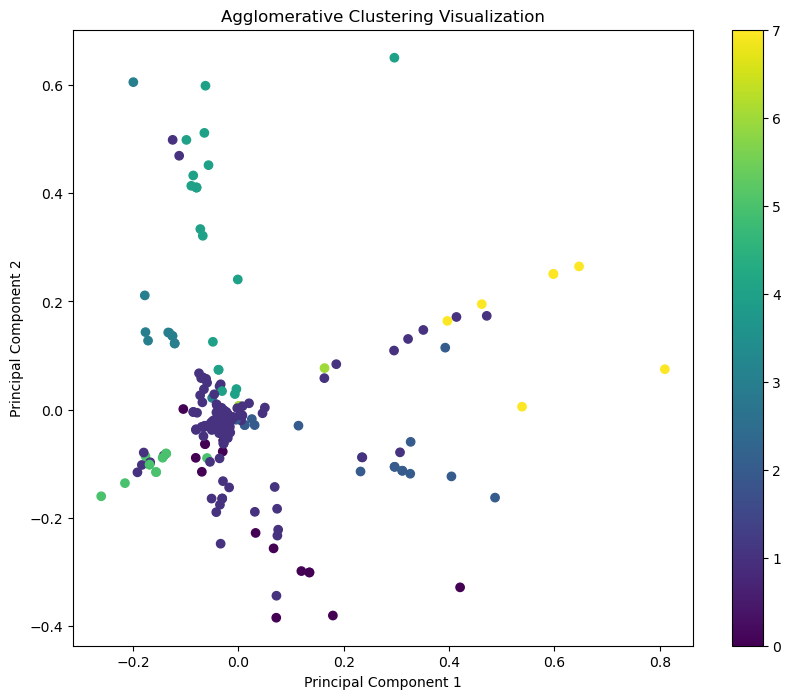

In [25]:
# Понижаем размерность до 2-х компонент с PCA
pca_2 = PCA(n_components=2)
transformed_features_2 = pca_2.fit_transform(corpus_vec_2.toarray())

# Визуализация
plt.figure(figsize=(10, 8))
plt.scatter(transformed_features_2[:, 0], transformed_features_2[:, 1], c=clusters_2, cmap='viridis')
plt.title('Agglomerative Clustering Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar()
plt.show()

In [26]:
feature_names_2 = tf_idf_2.get_feature_names_out()
for cluster_label in np.unique(clusters_2):
    top_words_2 = top_tfidf_words(cluster_label, corpus_vec_2, feature_names_2, clusters_2)
    print(f'Cluster {cluster_label}: {top_words_2}')

Cluster 0: ['карьера', 'результат', 'достижение']
Cluster 1: ['будущее', 'стать', 'жизнь']
Cluster 2: ['развитие', 'россия', 'рост']
Cluster 3: ['проект', 'реализация', 'навигатор']
Cluster 4: ['новый', 'знакомство', 'путешествие']
Cluster 5: ['работа', 'карьер', 'учеба']
Cluster 6: ['деньга', 'вдохновлять', 'интересный']
Cluster 7: ['человек', 'вдохновлять', 'понимать']


In [27]:
print("Качество кластеризации по метрике силуэтта %.3f" % silhouette_score(corpus_vec_2.toarray(), agg_clustering_2.labels_))
print(f'Davies Bouldin Score: {davies_bouldin_score(corpus_vec_2.toarray(), agg_clustering_2.labels_)}')

Качество кластеризации по метрике силуэтта 0.031
Davies Bouldin Score: 3.212881437121676


При настройке гиперпараметра linkage качество кластеризации увеличивается на маленьких датасетах с linkage='single', а на больших со стандартным расстоянием 'ward'. Проверим силуэт и davies_bouldin_score в кластерах.

In [28]:
# Загрузка данных из JSON файла
with open("D:\datasets/all/20963.json", 'r') as f:
    data_3 = json.load(f)

# Создаем список, в котором каждый элемент повторяется соответствующее количество раз
text_list_3 = [item['answer'] for item in data_3['answers']]
text_series_3 = pd.Series(text_list_3, name='text')
text_series_3.head()

0                        вертикаль
1                       взаимность
2    взаимовыгодное сотрудничество
3                      партнёрство
4                   сотрудничество
Name: text, dtype: object

In [29]:
text_series_3.count()

23

В этом датасете всего 23 примера

In [30]:
corpus_3 = text_series_3.apply(clean).apply(lemmatize_spacy)

In [31]:
tf_idf_3 = TfidfVectorizer(stop_words=all_stopwords)
corpus_vec_3 = tf_idf_3.fit_transform(corpus_3) 

In [32]:
agg_clustering_3 = AgglomerativeClustering(n_clusters=4)
clusters_3 = agg_clustering_3.fit_predict(corpus_vec_3.toarray())

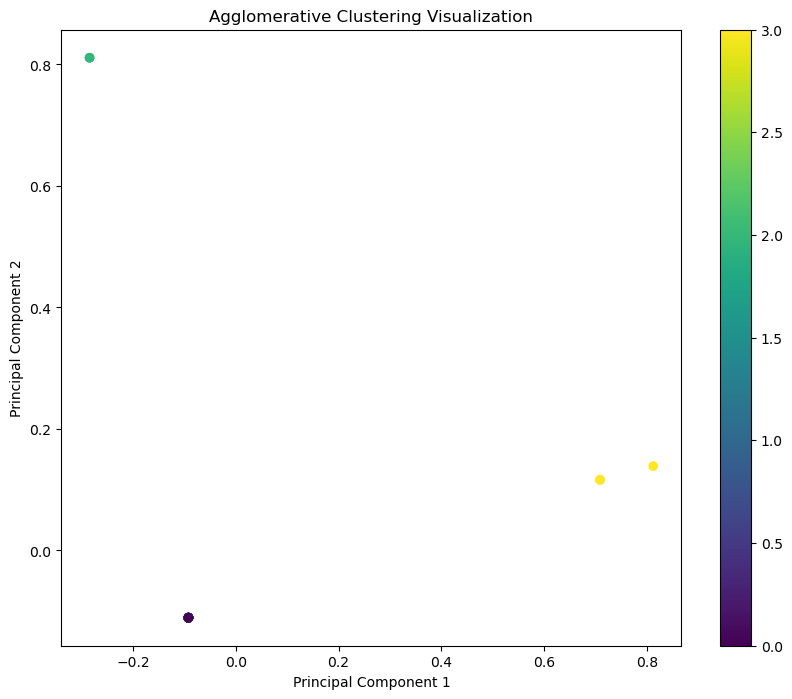

In [33]:
# Понижаем размерность до 2-х компонент с PCA
pca_3 = PCA(n_components=2)
transformed_features_3 = pca_3.fit_transform(corpus_vec_3.toarray())

# Визуализация
plt.figure(figsize=(10, 8))
plt.scatter(transformed_features_3[:, 0], transformed_features_3[:, 1], c=clusters_3, cmap='viridis')
plt.title('Agglomerative Clustering Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar()
plt.show()

In [34]:
feature_names_3 = tf_idf_3.get_feature_names_out()
for cluster_label in np.unique(clusters_3):
    top_words_3 = top_tfidf_words(cluster_label, corpus_vec_3, feature_names_3, clusters_3)
    print(f'Cluster {cluster_label}: {top_words_3}')

Cluster 0: ['общение', 'понимание', 'взаимность']
Cluster 1: ['простота', 'совместный', 'деятельность']
Cluster 2: ['сотрудничество', 'взаимовыгодный', 'эффективный']
Cluster 3: ['коммуникация', 'эффективный', 'дистанционный']


In [35]:
print("Качество кластеризации по метрике силуэтта %.3f" % silhouette_score(corpus_vec_3.toarray(), agg_clustering_3.labels_))
print(f'Davies Bouldin Score: {davies_bouldin_score(corpus_vec_3.toarray(), agg_clustering_3.labels_)}')

Качество кластеризации по метрике силуэтта 0.080
Davies Bouldin Score: 2.2045675150801074


Посмотрев на данные с маленьким количеством строк встал вопрос о настройке оптимального расстояния в кластерах и их количестве. Алгоритм с 8 кластерами хорошо показывает себя на датасетах c количеством ответов от 150. После автоматизации этого вопроса посмотрим, можно ли сделать токенизацию лучше.

Напишем функцию для выбора количества кластеров перед обучением модели. Максимальным количеством оставим 8 для удобства визуализации, для маленьких датасетов сделаем меньшее количество. По итогам проверки модели на разных файлах было решено выделить следующее кол-во кластеров в зависимости от кол-ва ответов:
1. 50 и менее ответов - 3 кластера
2. от 50 до 200 - 4 кластера
3. от 200 до 350 - 6 кластеров
4. от 350 - 8 кластеров

In [36]:
if text_series.count() <= 50:
     n = 3
elif text_series.count() <= 200:
     n = 4
elif text_series.count() <= 350:
     n = 5
else:
     n = 6
agg_clustering_prod = AgglomerativeClustering(n_clusters=n)

# Оптимизация токенизации и предобработки текста

Мы добились быстрой обработки текста, что является важным для специфика разрабатываемого сервиса, однако качество обработки текста не такое, как у больших предобученных моделей. Попробуем использовать предобученную модель LaBSE-en-ru для автоматической токенизации и векторизации текста.

In [37]:
# Инициализируем токенизатор и модель
tokenizer = AutoTokenizer.from_pretrained("cointegrated/LaBSE-en-ru")
model = AutoModel.from_pretrained("cointegrated/LaBSE-en-ru")

embeddings_list = []

for text in text_series_3:
    encoded_input = tokenizer(text, padding=True, truncation=True, max_length=64, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**encoded_input)
    embedding = model_output.pooler_output
    embeddings_list.append(embedding[0].numpy())

embeddings = np.asarray(embeddings_list)

Some weights of the model checkpoint at cointegrated/LaBSE-en-ru were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [38]:
agg_clustering_labse = AgglomerativeClustering(n_clusters=4)
clusters_labse= agg_clustering_labse.fit_predict(embeddings)

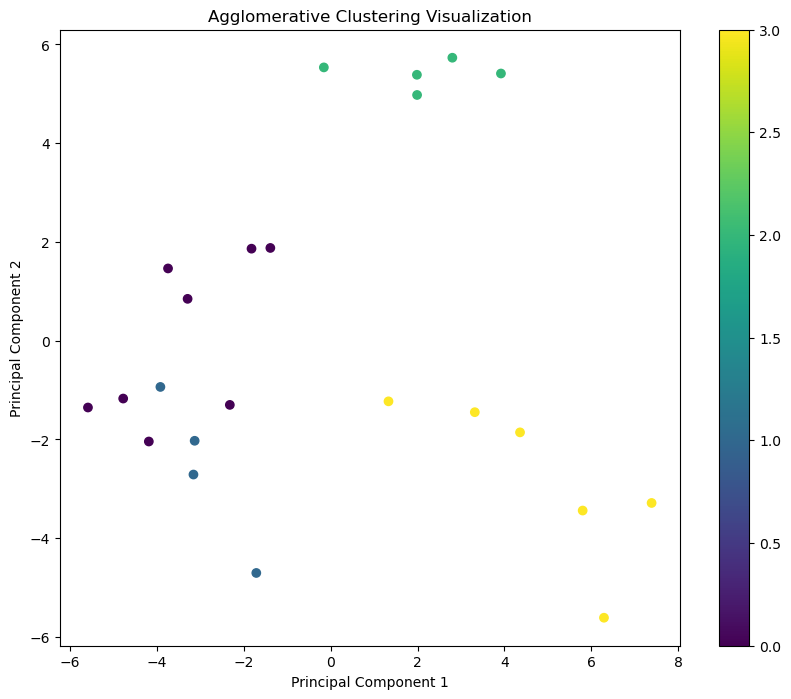

In [39]:
# Понижаем размерность до 2-х компонент с PCA
pca_labse = PCA(n_components=2)
transformed_features_labse = pca_labse.fit_transform(embeddings)

# Визуализация
plt.figure(figsize=(10, 8))
plt.scatter(transformed_features_labse[:, 0], transformed_features_labse[:, 1], c=clusters_labse, cmap='viridis')
plt.title('Agglomerative Clustering Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar()
plt.show()

In [40]:
# 1. Векторизация текстов
tfidf_vectorizer = TfidfVectorizer(max_features=1000)  # Указываете максимальное количество признаков
tfidf_matrix = tfidf_vectorizer.fit_transform(text_series_3)

# 2. Инвертирование индексов
feature_names = tfidf_vectorizer.get_feature_names_out()

# 3. Анализ весов
cluster_top_words = {}

for cluster_label in np.unique(clusters_labse):
    cluster_indices = np.where(clusters_labse == cluster_label)[0]
    cluster_tfidf_scores = tfidf_matrix[cluster_indices].sum(axis=0).A1

    # 4. Получение топ слов
    top_indices = np.argsort(cluster_tfidf_scores)[::-1][:3]  # топ 3 слова
    top_words = [feature_names[i] for i in top_indices]

    cluster_top_words[cluster_label] = top_words

# Выведем топ слов для каждого кластера
for cluster_label, top_words in cluster_top_words.items():
    print(f'Cluster {cluster_label}: {top_words}')


Cluster 0: ['удобство', 'взаимность', 'простота']
Cluster 1: ['вертикаль', 'расстояние', 'последовательность']
Cluster 2: ['сотрудничество', 'кооперация', 'партнёрство']
Cluster 3: ['коммуникация', 'общение', 'комауникация']


Слова для лейблинга получились лучше сгруппированы, чем в модели с более простой предобработкой и векторизацией. По визуализации видно, что в целом разметка кластеров получилась более качественной. Однако этот способ нам не подходит, так как на предобработку вопроса с 23 ответами ушло более 14 секунд, что может очень сильно сказаться на скорости загрузки визуализации для пользователя. При дальнейшей адаптации можно добиться ускорения.

In [41]:
print(f"Качество кластеризации по метрике силуэтта {silhouette_score(embeddings, agg_clustering_labse.labels_)}")
print(f'Davies Bouldin Score: {davies_bouldin_score(embeddings, agg_clustering_labse.labels_)}')

Качество кластеризации по метрике силуэтта 0.1360253095626831
Davies Bouldin Score: 1.8835664286721732


Метрики выросли не на много, однако качество лейблинга кластеров и их определение на визуальных примерах выросла значительно, что говорит о том, что для данной задачи метрика не дает ничего для оценки модели.

# Выводы

В рамках подготовки модели для сервиса была проведена следующая работа:
1.	Провел общий обзор данных, определена задача для обучения модели;
2.	Выбрал основной метод предобработки и векторизации текста с помощью spacy и Tf-Idf;
3.	Проверил работоспособность моделей кластеризации K-Means, DBSCAN и Agglomerative Clustering, за основу выбрана последняя;
4.	Модель протестировал на разных вариантах датасетов, что подтвердило ее эффективность для лейблинга кластеров на дальнейшей визуализации для пользователя
5.	Проверил предобработку текста с помощью LaBSE на выбранной модели, обосновал, почему не получится применить в текущей итерации сервиса.

Основная проблема заказчика на данном этапе решена – модель предоставляет возможность создания онлайн-опросника с автоматической визуализацией кластеризации ответов в реальном времени. С помощью топ 3 слов кластера получилось обозначить семантический смысл разделения пользовательских ответов на группы, а также удалось добиться высокой скорости предобработки текста и обучения, что позволит улучшить клиентский опыт с точки зрения ожидания результатов и их качества. <br> Основная проблема данной задачи состояла в том, что алгоритм должен быть максимально универсальным, так как опросы на сайте могут быть абсолютно любой направленности, а количество ответов очень сильно разнится от случая к случаю. Текущая версия модели позволяет с хорошей точностью разделить пользовательские ответы на группы с визуальным представлением на сайте. <br>В дальнейшем можно еще повысить качество модели, что было показано в пункте 5, однако на данном этапе у команды не хватает технических мощностей для реализации предобработки текста предобученной моделью, так как скорость обработки слишком низкая, что на данном этапе сильно ухудшит пользовательский опыт.